In [4]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import random
import lightgbm as lgb
import re
from sklearn.metrics import *
from sklearn.model_selection import KFold
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

# 필요한 함수 정의
def make_datetime(x):
    # string 타입의 Time column을 datetime 타입으로 변경
    x     = str(x)
    year  = int(x[:4])
    month = int(x[4:6])
    day   = int(x[6:8])
    hour  = int(x[8:10])
    #mim  = int(x[10:12])
    #sec  = int(x[12:])
    return dt.datetime(year, month, day, hour)

def string2num(x):
    # (,)( )과 같은 불필요한 데이터 정제
    x = re.sub(r"[^0-9]+", '', str(x))
    if x =='':
        return 0
    else:
        return int(x)
    
PATH ='C:\\Users\\lg\\Desktop\\로그 분석\\'

학습 데이터 (user_id : 10000 ~ 24999, 15000명)


train_err_data.csv : 시스템에 발생한 에러 로그

train_quality_data.csv : 시스템 퀄리티 로그

train_problem_data.csv : 사용자 불만 및 불만이 접수된 시간



테스트 데이터(user_id : 30000 ~ 44998, 14999명)


test_err_data.csv : 시스템에 발생한 에러 로그

test_quality_data.csv : 시스템 퀄리티 로그

sample_submission.csv : 사용자 불만 확률(0~1) (제출용)

# 2. 학습 데이터 생성

## 2.1 train_err

- train_err_data.csv 파일의 errtype column의 value_counts를 카운트하여 학습에 사용.
- 주어진 기간동안 user_id별로 problem가 한 번이라도 발생했는지를 확인

In [5]:
train_err = pd.read_csv(PATH+'train_err_data.csv')
display(train_err.head())

,user_id,time,model_nm,fwver,errtype,errcode
0,10000,20201101025616,model_3,05.15.2138,15,1
1,10000,20201101030309,model_3,05.15.2138,12,1
2,10000,20201101030309,model_3,05.15.2138,11,1
3,10000,20201101050514,model_3,05.15.2138,16,1
4,10000,20201101050515,model_3,05.15.2138,4,0


In [6]:
test_err = pd.read_csv(PATH + 'test_err_data.csv')
display(test_err.head())

,user_id,time,model_nm,fwver,errtype,errcode
0,30000,20201101030227,model_1,04.16.3553,31,1
1,30000,20201101030227,model_1,04.16.3553,33,2
2,30000,20201101030228,model_1,04.16.3553,15,1
3,30000,20201101030256,model_1,04.16.3553,22,1
4,30000,20201101030300,model_1,04.16.3553,11,1


In [7]:
combine = [train_err, test_err]

In [9]:
display(combine)

[          user_id            time model_nm       fwver  errtype errcode
 0           10000  20201101025616  model_3  05.15.2138       15       1
 1           10000  20201101030309  model_3  05.15.2138       12       1
 2           10000  20201101030309  model_3  05.15.2138       11       1
 3           10000  20201101050514  model_3  05.15.2138       16       1
 4           10000  20201101050515  model_3  05.15.2138        4       0
 ...           ...             ...      ...         ...      ...     ...
 16554658    24999  20201130163051  model_3  05.15.2138       15       1
 16554659    24999  20201130172625  model_3  05.15.2138       16       1
 16554660    24999  20201130172625  model_3  05.15.2138        4       0
 16554661    24999  20201130172631  model_3  05.15.2138        4       0
 16554662    24999  20201130210625  model_3  05.15.2138       15       1
 
 [16554663 rows x 6 columns],
           user_id            time model_nm       fwver  errtype errcode
 0           30000 

In [3]:
# 데이터 설명을 확인하면
# ueser_id가 10000부터 24999까지 총 15000개가 연속적으로 존재.
display(train_err.head())
train_user_id_max = 24999
train_user_id_min = 10000
train_user_number = 15000

,user_id,time,model_nm,fwver,errtype,errcode
0,10000,20201101025616,model_3,05.15.2138,15,1
1,10000,20201101030309,model_3,05.15.2138,12,1
2,10000,20201101030309,model_3,05.15.2138,11,1
3,10000,20201101050514,model_3,05.15.2138,16,1
4,10000,20201101050515,model_3,05.15.2138,4,0


In [4]:
print(np.sort(train_err.errtype.unique()))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 30 31 32 33 34 35 36 37 38 39 40 41 42]


- errtype이 1부터 42까지 29를 제외한 41개가 존재.

In [5]:
id_error = train_err[['user_id', 'errtype']].values
error = np.zeros((train_user_number, 42))

for person_idx, err in tqdm(id_error):
    # person_idx - train_user_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    error[person_idx - train_user_id_min, err -1] += 1

100%|██████████████████████████████████████████████████████████████████| 16554663/16554663 [00:48<00:00, 338479.76it/s]


- index별로 어떠한 에러코드가 떳는지 알 수 있다.

# fwver

<AxesSubplot:>

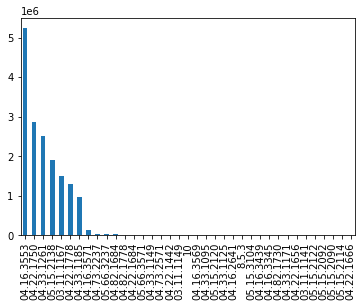

In [6]:
train_err['fwver'].value_counts().plot(kind = 'bar')

- fwver = 펌웨어버전은 몇몇 개의 펌웨어 버전에서 두드러지게 나타난다.

## model_nm

In [7]:
train_err.model_nm.value_counts()

model_1    5384491
model_0    4176279
model_2    3473254
model_3    1907438
model_4    1507802
model_8      36064
model_7      35356
model_5      32233
model_6       1746
Name: model_nm, dtype: int64

<AxesSubplot:>

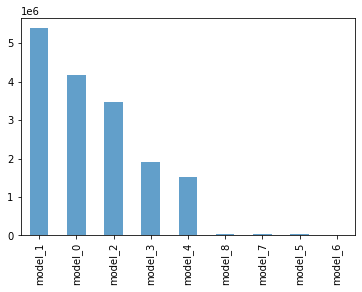

In [8]:
train_err['model_nm'].value_counts().plot(kind = 'bar', alpha = 0.7)

- model_nm은 1이 가장 많고 6이 가장 적다.

# errcode

In [9]:
train_err['errcode'].isnull().sum()

1

- train_err의 errcode에 결측치가 있고 이것을 최빈값으로 넣어주자.

In [10]:
train_err['errcode'].value_counts()

1                     8906967
0                     2599123
connection timeout    1835600
B-A8002                897863
80                     334018
                       ...   
5760                        1
3234                        1
3565                        1
6513                        1
10945                       1
Name: errcode, Length: 2805, dtype: int64

- 최빈값은 1이고 이것을 넣어주자. 

In [11]:
train_err['errcode'].isnull().sum()
train_err['errcode']=train_err['errcode'].fillna(1)
train_err['errcode'].isnull().sum()

0

In [12]:
len(train_err['errcode'].unique())

2806

- 2806개의 값들이 있고 그래프로 그려주기에 한계가 있다고 생각된다.

<AxesSubplot:>

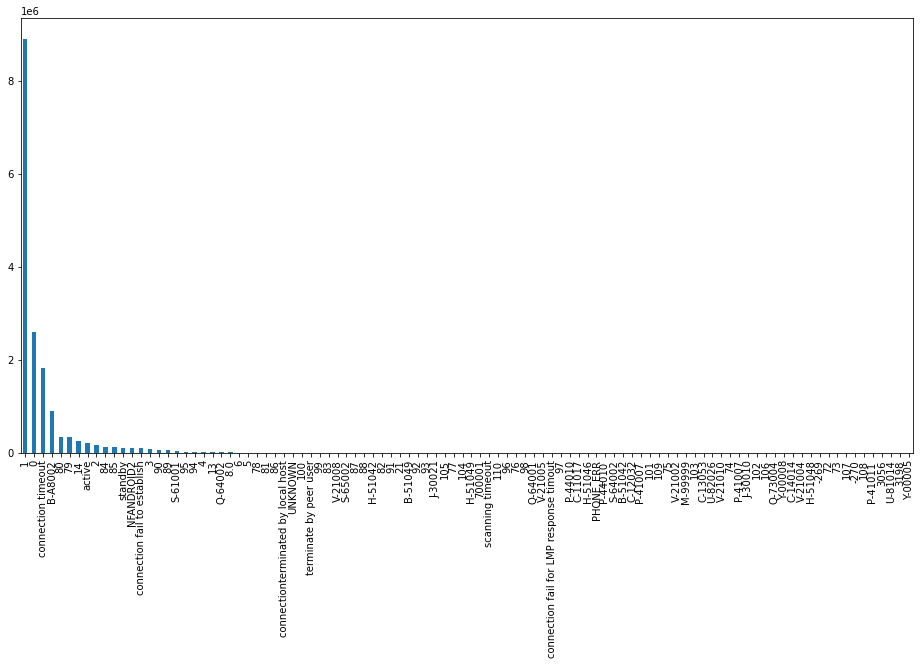

In [13]:
train_err['errcode'].value_counts()[:100].plot(kind = 'bar', figsize = (16,8))

- 몇가지의 errcode말고는 전부 확인하기 어려울정도로 빈도가 적다.

# errtype

<AxesSubplot:>

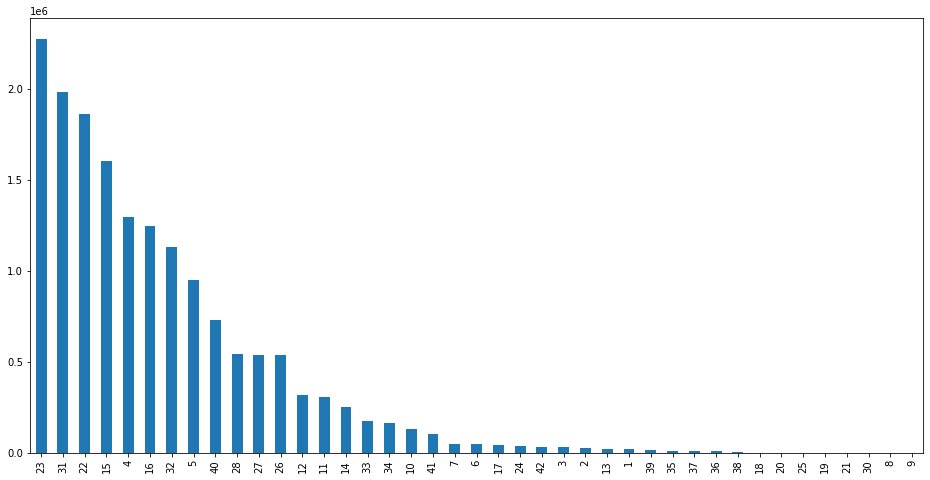

In [14]:
train_err['errtype'].value_counts().plot(kind='bar', figsize = (16,8), )

- 그래프로 시각화 하였을 때 뚜렷한 비교대상을 찾을 수 없다.

# time

<AxesSubplot:>

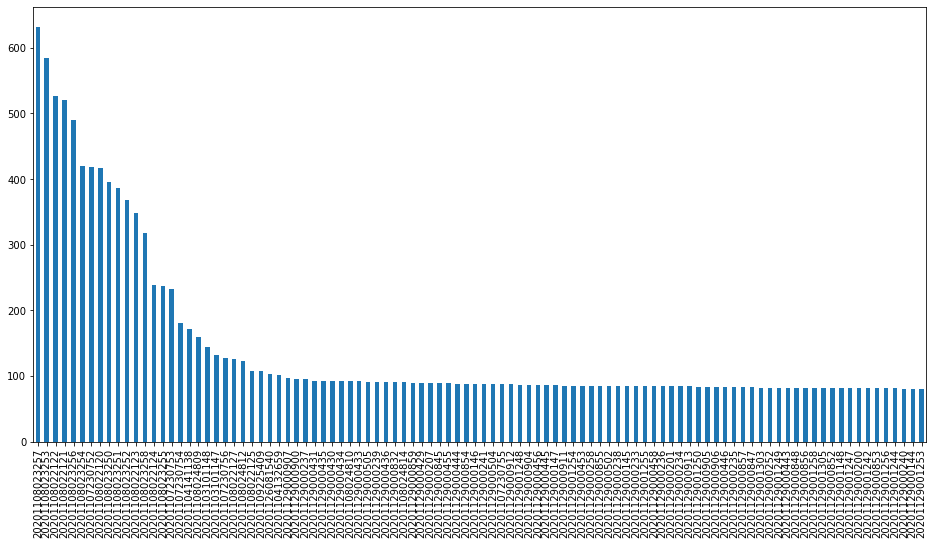

In [15]:
train_err['time'].value_counts()[:100].plot( kind = 'bar', figsize = (16,8))

In [16]:
train_err['errcode1'] = train_err['errcode'].apply(string2num)

# 2개의 변수들끼리 비교

<AxesSubplot:>

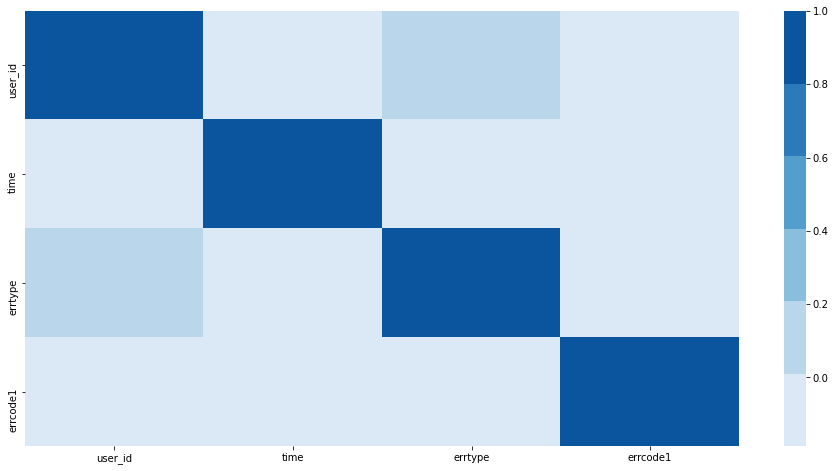

In [17]:
# 전체 데이터에 대한 상관관계 HeatMap 시각화
corr = train_err.corr()
cmap = sns.color_palette("Blues")
f, ax = plt.subplots(figsize=(16,8))
sns.heatmap(corr, cmap=cmap)

<AxesSubplot:ylabel='Density'>

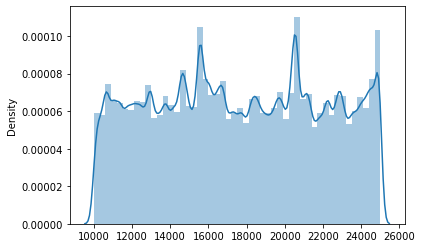

In [20]:
sns.distplot(x = train_err['user_id'])

<AxesSubplot:xlabel='errtype', ylabel='count'>

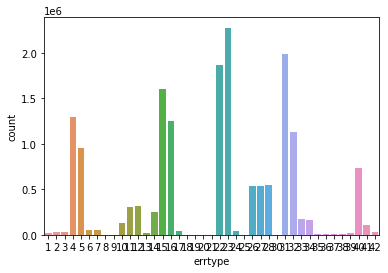

In [21]:
sns.countplot(x = train_err['errtype'])

In [22]:
train_err.head()

,user_id,time,model_nm,fwver,errtype,errcode,errcode1
0,10000,20201101025616,model_3,05.15.2138,15,1,1
1,10000,20201101030309,model_3,05.15.2138,12,1,1
2,10000,20201101030309,model_3,05.15.2138,11,1,1
3,10000,20201101050514,model_3,05.15.2138,16,1,1
4,10000,20201101050515,model_3,05.15.2138,4,0,0


- model_nm을 보면 model_3이외s의

<AxesSubplot:xlabel='model_nm', ylabel='Count'>

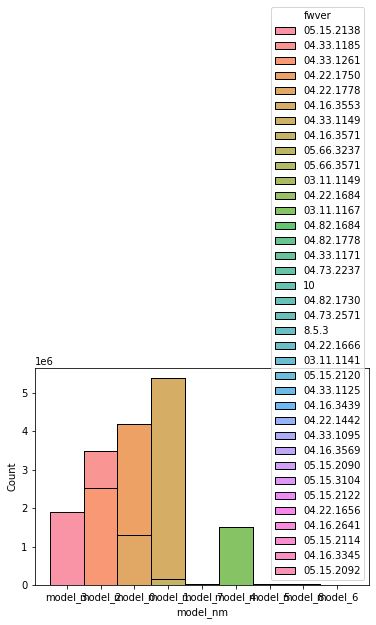

In [23]:
sns.histplot(data = train_err, x = train_err['model_nm'], hue = train_err['fwver'],multiple = 'stack')

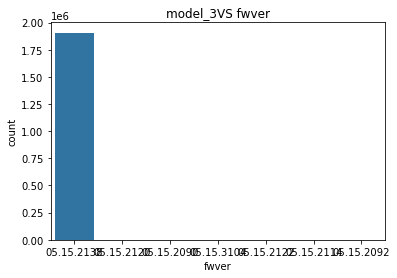

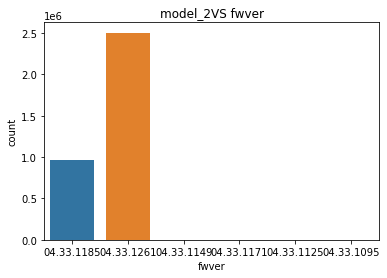

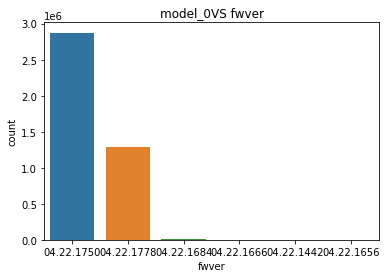

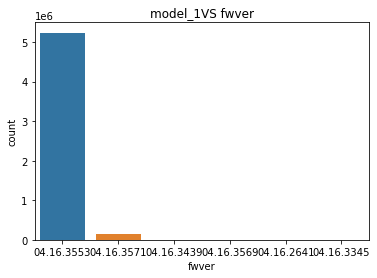

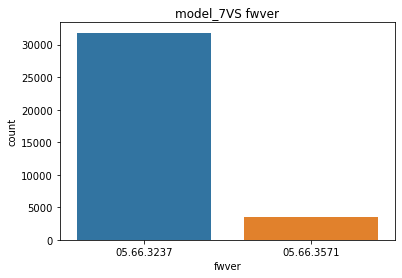

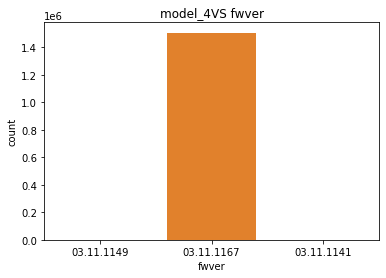

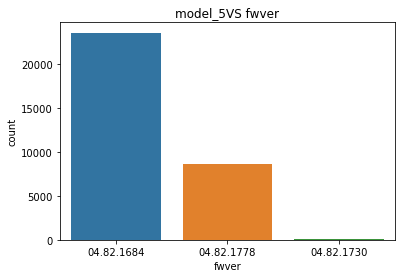

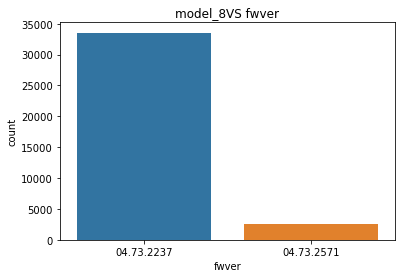

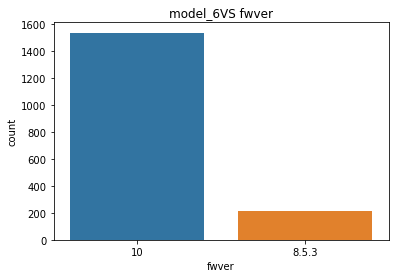

In [29]:
for i in train_err['model_nm'].unique():    
    sns.countplot(x = train_err[train_err['model_nm'] == i]['fwver'])
    plt.title(i + 'VS fwver')
    plt.show()

- model_nm별로 나오는 fwver의 종류가 다르므로 확인해 볼 필요가 있다.

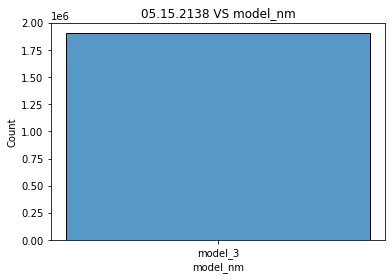

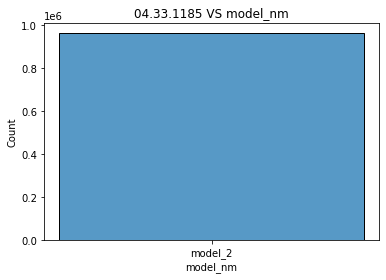

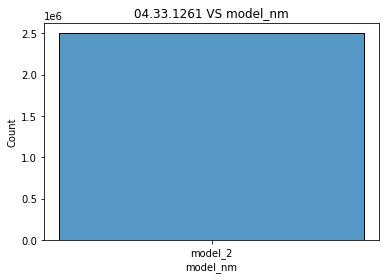

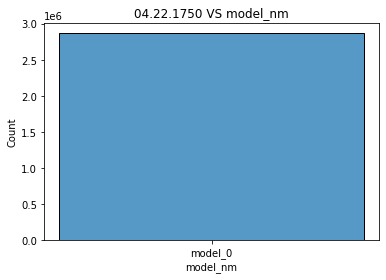

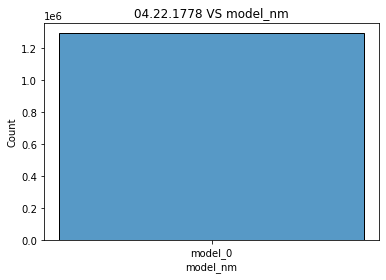

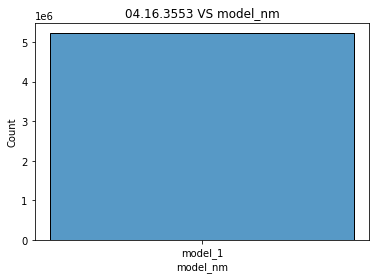

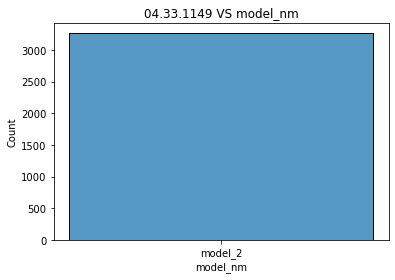

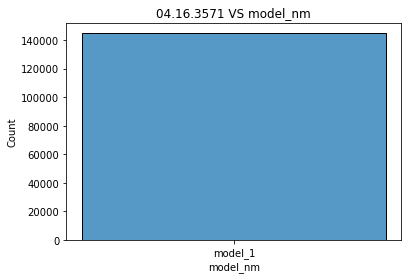

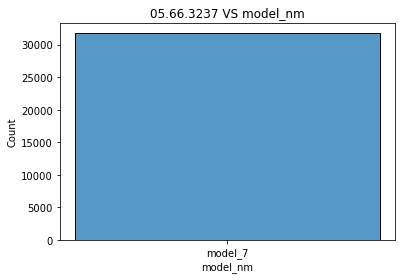

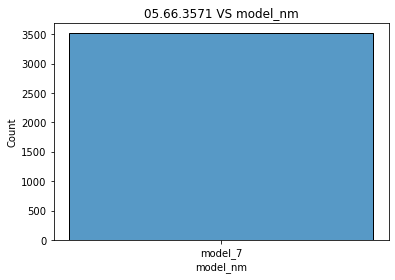

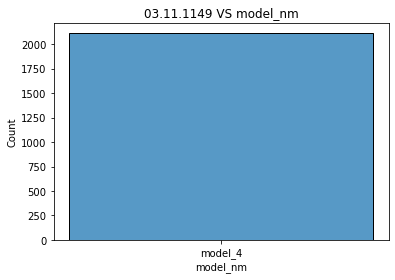

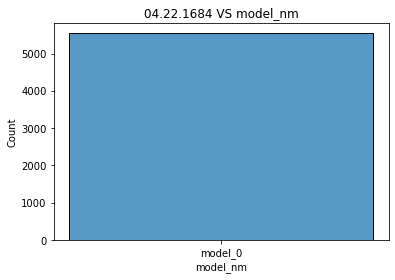

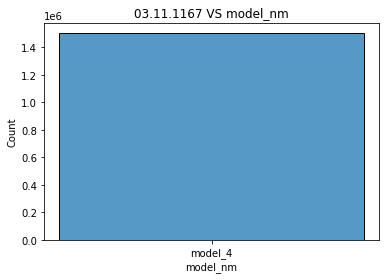

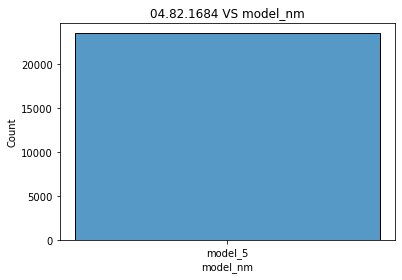

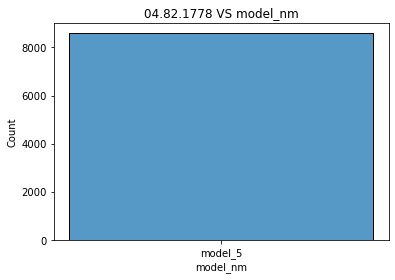

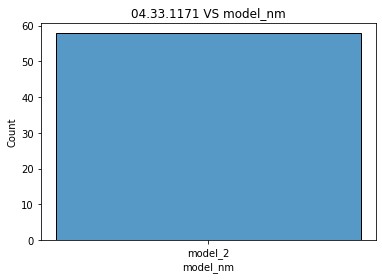

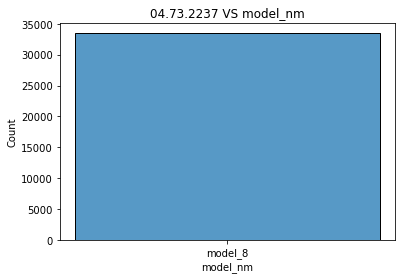

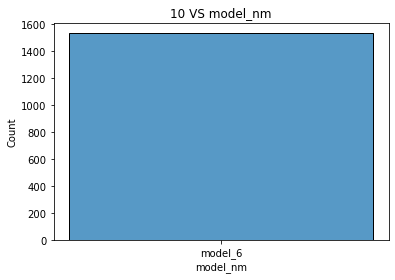

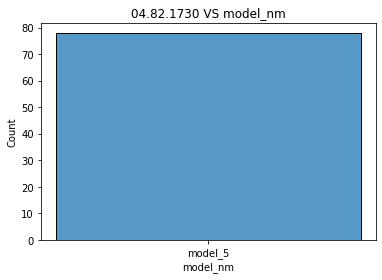

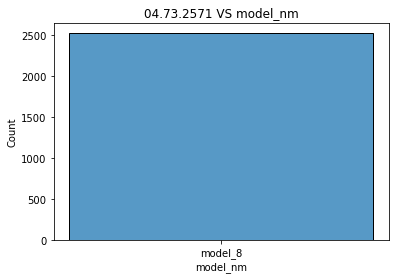

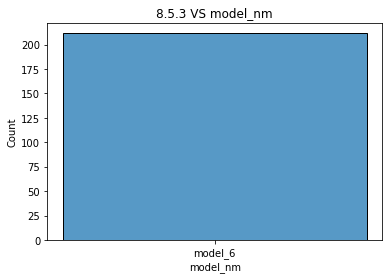

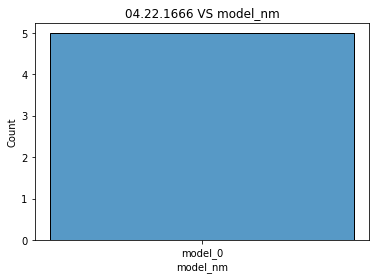

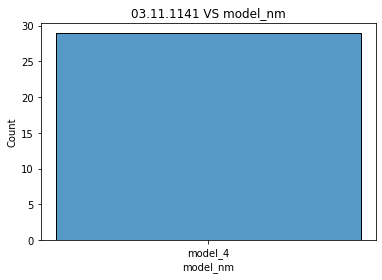

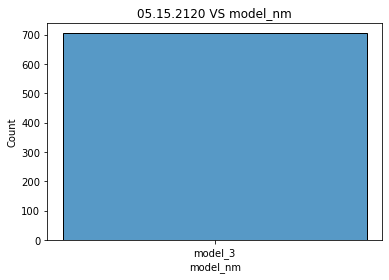

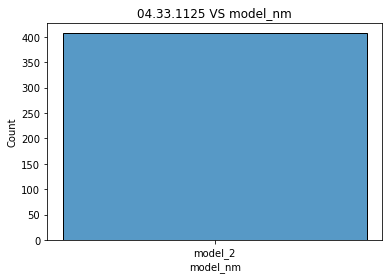

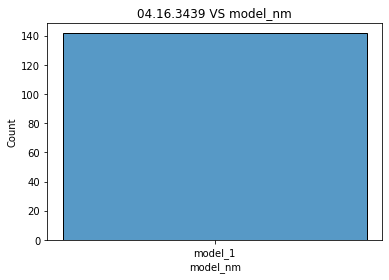

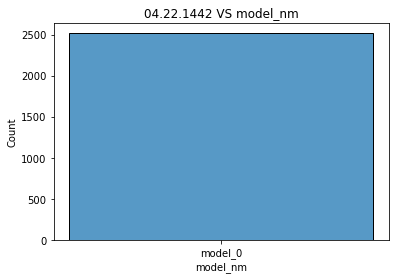

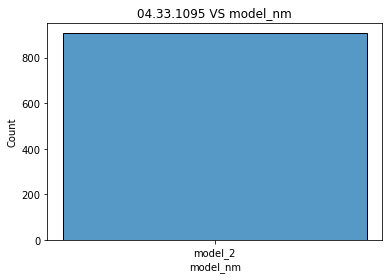

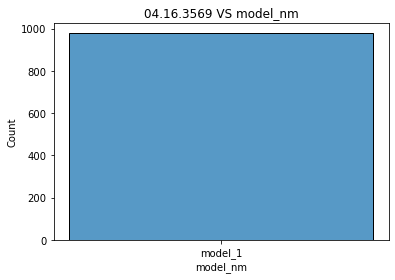

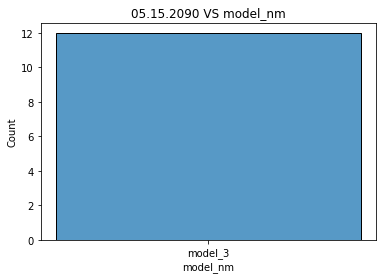

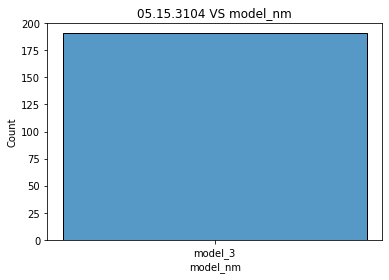

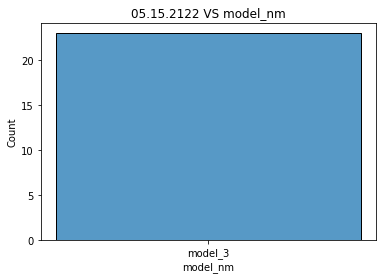

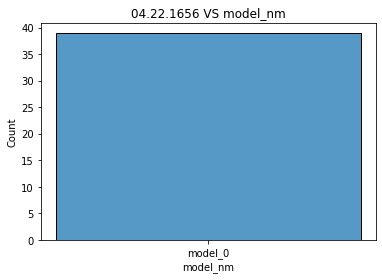

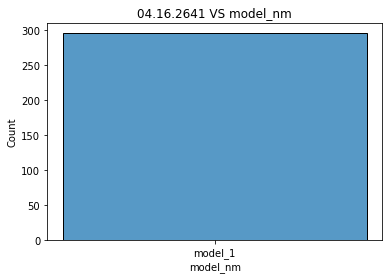

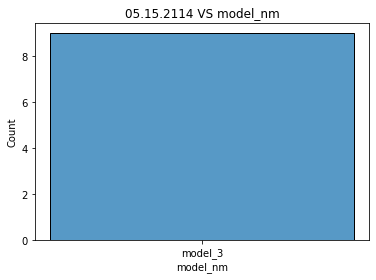

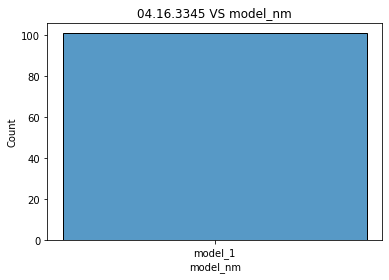

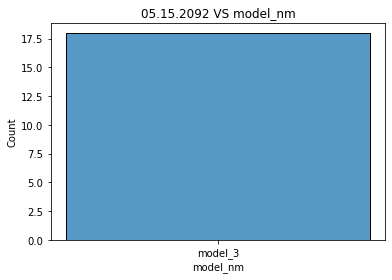

In [32]:
for i in train_err['fwver'].unique():
    sns.histplot(train_err[train_err['fwver'] == i]['model_nm'])
    plt.title( i + ' VS model_nm')
    plt.show()

- fwver는 하나의 model명을 대표한다?

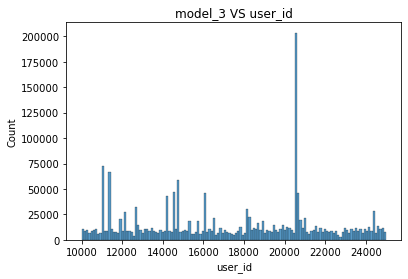

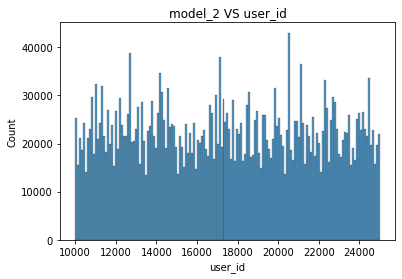

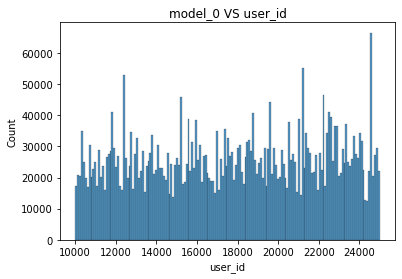

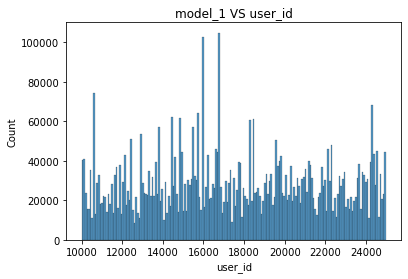

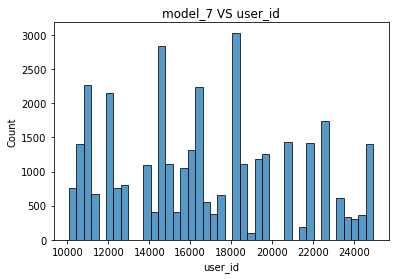

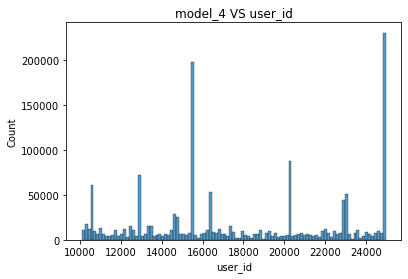

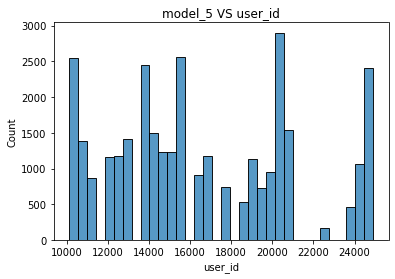

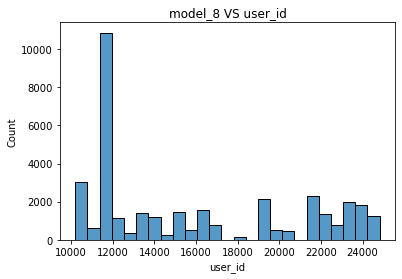

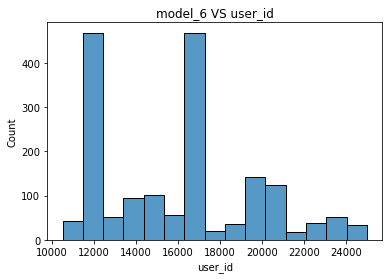

In [42]:
for i in train_err['model_nm'].unique():
    sns.histplot(train_err[train_err['model_nm'] == i]['user_id'])
    plt.title(i + ' VS user_id')
    plt.show()

- ###############################################################################

In [64]:
train_err['errcode'].value_counts()

1                     8906967
0                     2599123
connection timeout    1835600
B-A8002                897863
80                     334018
                       ...   
5743                        1
6647                        1
3537                        1
5437                        1
1                           1
Name: errcode, Length: 2806, dtype: int64

In [65]:
train_err['errcode1'].value_counts()

1       8906970
0       4876463
8002     897863
80       343335
79       332422
         ...   
3851          1
3855          1
3857          1
3859          1
8186          1
Name: errcode1, Length: 2774, dtype: int64

In [ ]:
train_prob = pd.read_csv(PATH + 'train_problem_data.csv')
problem = np.zeros(15000)

In [ ]:
train_prob

In [ ]:
problem[train_prob['user_id'].unique()-10000] = 1
problem.shape

- 문제가 한번이라도 일어났으면 1 아니면 0 으로 기입한다.

In [ ]:
train_x = error
train_y = problem
del error, problem
print(train_x.shape)
print(train_y.shape)

In [ ]:
def f_pr_auc(probas_pred, y_true):
    labels=y_true.get_label()
    p, r, _ = precision_recall_curve(labels, probas_pred)
    score=auc(r,p) 
    return "pr_auc", score, True

- validation auc score을 위하여 생성한다.

In [ ]:
models     = []
recalls    = []
precisions = []
auc_scores   = []
threshold = 0.5
# 파라미터 설정
params =      {
                'boosting_type' : 'gbdt',
                'objective'     : 'binary',
                'metric'        : 'auc',
                'seed': 1015
                }

- 파라미터를 전부 설정해 주어야 하고 나중에 append시키기 위해서 리스트 형태로 생성해 놓는다.

- 교차검증의 목적은 모델의 일반화를 위해서다.

In [ ]:
# 5 Kfold cross validation
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, val_idx in k_fold.split(train_x):

    # split train, validation set
    X = train_x[train_idx]
    y = train_y[train_idx]
    valid_x = train_x[val_idx]
    valid_y = train_y[val_idx]

    d_train= lgb.Dataset(X, y)
    d_val  = lgb.Dataset(valid_x, valid_y)
    
    #run traning
    model = lgb.train(
                        params,
                        train_set       = d_train,
                        num_boost_round = 1000,
                        valid_sets      = d_val,
                        feval           = f_pr_auc,
                        verbose_eval    = 20, 
                        early_stopping_rounds = 3
                       )